<a id="top"></a>
# Look For Transients In FFI's In Nearby Galaxies
***

## Prerequisites
Before beginning this tutorial, you should be familiar with: 
- Python syntax, including [for loops](https://www.py4e.com/html3/05-iterations)
- [astropy tables](https://docs.astropy.org/en/stable/table/index.html)
- [astropy Time objects](https://docs.astropy.org/en/stable/time/index.html)
- Types of [extragalactic transients](https://astrobites.org/2022/10/30/guide-to-transient-astronomy/)
- [lightkurve TargetPixelFile objects](https://docs.lightkurve.org/tutorials/1-getting-started/what-are-targetpixelfile-objects.html)

## Learning Goals

By the end of this tutorial, you will:

- Use ``Observations.query_criteria`` to find the fields of view, start times, and end times of all TESS full frame images (FFIs)
- Load an online table of transient events as an astropy table
- Determine if a transient event (based on location and time) was observed by TESS
- Use ``lightkurve`` and ``tesscut`` to extract the background-subtracted lightcurve of a single pixel centered on a transient event

## Introduction

The primary mission of the [Transiting Exoplanet Survey Satellite (TESS)](https://archive.stsci.edu/missions-and-data/tess) is to detect Earth-sized planets orbiting bright stars. Though much of the further pipeline analysis focuses on those bright stellar targets, Full Frame Images (FFIs) of the entire 24$^\circ$ by 96$^\circ$ field-of-view are available for download and analysis. Each 24$^\circ$ by 96$^\circ$ sector is observed for about 27 days, and many sectors are overlapping. 

This means that other interesting targets can be observed in the TESS FFIs; here, we focus on known extragalactic transients, such as supernovae. We will focus on the transients reported by the Zwicky Transient Facility (ZTF). The ZTF scans the entire Northern hemisphere sky every two days; objects we find here will also likely have follow-up data from e.g. Pan-STARRS. How many of these targets were being observed by the TESS cameras during the transient event? Though it is possible to query the MAST archive by coordinate or object name, this is a very inefficient process for many targets. To efficiently conduct this analysis for thousands of transients, we will first find time and coordinate information from the FFI's directly from the MAST archive and then use that information to do our own searching with in the FFI's. Finally, we will focus on one observed transient and extract a background-subtracted light curve of a single pixel. 

The workflow for this notebook consists of:
* [Load the list of transients from ZTF](#Load-the-list-of-transients-from-ZTF)
* [Get dates and coordinates of TESS FFIs from MAST](*Get-dates-and-coordinates-of-TESS-FFIs-from-MAST*)
    * [Exercise 1](#Exercise-1)
* [See which transients were observed by TESS at the right time](#See-which-transients-were-observed-by-TESS-at-the-right-time)
    * [Setup SkyCoord and DateTime objects](#Setup-SkyCoord-and-DateTime-objects)
    * [Exercise 2](#Exercise-2)
    * [Search the FFI table for transient objects](#Search-the-FFI-table-for-transient-objects)
* [Use TESScut and lightkurve to view the lightcurve of one transient event](#Use-TESScut-and-lightkurve-to-view-the-lightcurve-of-one-transient-event)
    * [Determine the desired TESS sector for our target](#Determine-the-desired-TESS-sector-for-our-target)
    * [Use TESSCut to create a postage stamp of our target](#Use-TESSCut-to-create-a-postage-stamp-of-our-target)
    * [Create a background-subtracted lightcurve](#Create-a-background-subtracted-lightcurve)
* [Additional Exercises](#Additional-Exercises)

## Imports
- *matplotlib.pyplot* for plotting data
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *astroquery.mast Mast* and *Observations* for searching the MAST archive
- *astropy.coordinates SkyCoord, astropy.time Time*, and *astropy.units u* for keeping track of sky coordinates, dates and times, and units, respectively
- *astroquery.mast Tesscut* for downloading target-pixel files from TESS data
- *lightkurve* for creating and viewing lightcurves from TESS data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Mast
from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
from astroquery.mast import Tesscut
import lightkurve as lk

***

## Load the list of transients from ZTF

Tables from the Zwicky Transient Facility [ZTF Bright Transient Survey](https://sites.astro.caltech.edu/ztf/bts/bts.php) are available online. In the ZTF Bright Transient Survey Sample (BTSS) Explorer, we can make a selection of criteria and produce a list of targets; the resulting URL can be pasted directly into our notebook and loaded into an astropy table. The only criterion we will choose is a peak magnitude of less than or equal to 19.0 (or, brighter than a certain threshold; the stellar magnitude system is explained [here by Sky & Telescope](https://skyandtelescope.org/astronomy-resources/the-stellar-magnitude-system/) or [here by OpenStax Astronomy 2e](https://openstax.org/books/astronomy-2e/pages/17-1-the-brightness-of-stars)). We'll also choose CSV as the output. 

In [2]:
url='https://sites.astro.caltech.edu/ztf/bts/explorer.php?f=s&subsample=trans&classstring=&classexclude=&ztflink=lasair&lastdet=&startsavedate=&startpeakdate=&startra=&startdec=&startz=&startdur=&startrise=&startfade=&startpeakmag=&startabsmag=&starthostabs=&starthostcol=&startb=&startav=&endsavedate=&endpeakdate=&endra=&enddec=&endz=&enddur=&endrise=&endfade=&endpeakmag=19.0&endabsmag=&endhostabs=&endhostcol=&endb=&endav=&reverse=y&format=csv'
tab=Table.read(url,format='csv')

In [3]:
tab

ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
str12,str10,str11,str11,float64,str1,float64,str6,str8,str7,str8,str10,str7,float64,float64
ZTF23aarriri,AT2023nbr,00:42:55.19,-09:13:56.7,2138.93,g,18.6141,-19.11,>3.03,>0,>3.03,SN Ia,0.0762,-71.9913452,0.097
ZTF23aarqyio,SN2023mzb,20:01:26.08,-25:12:21.4,2142.93,r,18.1741,-17.64,>3.267,3.267,>0,SN Ia,0.03,-25.86942531,0.302
ZTF23aarlxdf,AT2023mxi,00:43:41.78,+40:52:22.9,2138.93,g,16.6968,-,>1.159,>0,>1.159,nova,-,-21.97486432,0.17
ZTF23aarfqmx,SN2023jqw,22:29:08.02,-22:11:40.5,2141.92,r,18.7654,-17.38,>4.98,>4.98,>0,SN II,0.038,-57.403091,0.081
ZTF23aaqxlpn,SN2023mvl,19:41:40.47,-21:15:45.7,2141.89,r,18.4569,-18.38,>4.236,4.236,>0,SN Ia,0.04827,-20.22512516,0.275
ZTF23aaqvofl,SN2023msg,03:20:13.50,+40:41:07.2,2139.98,r,18.3123,-18.59,>5.01,>5.01,>0,SN Ia,0.04804,-13.90569375,0.365
ZTF23aaquhcv,SN2023mpy,20:32:20.71,+08:19:59.7,2140.84,g,18.9762,-19.29,>6,>5.97,>0.03,SN Ia,0.087,-18.01235668,0.302
ZTF23aaqtcxl,SN2023mmk,14:22:27.98,+23:06:13.1,2140.7,g,18.1966,-19.13,>5.96,>5.96,>0,SN Ia,0.06394,69.03641461,0.085
ZTF23aaqqjxv,SN2023mmz,02:03:24.07,+39:42:28.5,2133.96,g,18.3774,-19.56,>0.05,>0.05,>0,SN Ia,0.079,-21.09301584,0.201


More information about the columns can be found in the [ZTF Bright Transient Survey Sample Explorer documentation](https://sites.astro.caltech.edu/ztf/bts/explorer_info.html). The columns we are most interested in are:
- ``RA`` and ``Dec``, which we'll use to see if these targets are in any TESS sectors.
- ``time``, the time of the peak brightness, expressed as JD-2458000.
- ``rise``, the rise time (in days) from half-peak to peak.
- ``fade``, the fade time (in days) from peak to half-peak

Notice that some of the rise and fade times are lower limits. 

## Get dates and coordinates of TESS FFIs from MAST

The [TESS Observations](https://tess.mit.edu/observations/) page provides useful tables, including the start/end times of each sector's observing period and the coordinates of each camera during the sector.  We can cleverly use a query to the MAST archive to find this same information, and then determine if a known transient phenomenon was observed by TESS. Let's use the [astropy.mast Observations.query_criteria](https://astroquery.readthedocs.io/en/latest/mast/mast.html#observation-criteria-queries) function to view a table of all of the TESS Full Frame Images (FFI's). The key is to know that these are found using `target_name='TESS FFI'`. After returning the results table, we'll see how long it is, sort it by `t_min` (the observation start time; see below), and view the first three rows.

In [4]:
FFIs = Observations.query_criteria(project='TESS',target_name='TESS FFI')
print('Length of FFI table: ',len(FFIs))
FFIs.sort('t_min')
FFIs[0:3]

Length of FFI table:  1040


intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str4,str10,str4,str4,str7,str8,str1,str14,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str1,float64,str3,str1,int64,str138,str1,str1,str6,bool,float64,str9,str9
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0001-4-4,90.1643281891118,-57.92584112870806,image,"Ricker, George",3,58324.81152043981,58352.665975219905,1425.599428,600.0,1000.0,--,58458.5833333,N/A,--,1,POLYGON 105.899667 -56.995715 90.217793 -66.365128 74.608816 -56.588676 90.126494 -49.786515 105.899667 -56.995715,--,--,PUBLIC,False,nan,60865633,112737321
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0001-4-3,111.02618019992941,-65.25129027308752,image,"Ricker, George",3,58324.811805763886,58352.66567248842,1425.599428,600.0,1000.0,--,58458.5833333,N/A,--,1,POLYGON 127.603843 -61.771365 121.073669 -72.986467 90.505928 -66.484247 106.156464 -57.080944 127.603843 -61.771365,--,--,PUBLIC,False,nan,60865632,112737249
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0001-4-1,69.43886632081164,-64.91659705929159,image,"Ricker, George",3,58324.81275704861,58352.66720539352,1425.599428,600.0,1000.0,--,58458.5833333,N/A,--,1,POLYGON 53.472874 -61.115537 74.173119 -56.729652 89.699294 -66.564985 59.740565 -72.687978 53.472874 -61.115537,--,--,PUBLIC,False,nan,60865630,112737000


The MAST documentation includes more information about these [table columns](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html). Some of the most important columns for our purposes will be:
- `obds_id` which we can parse into the sector name, camera number, and the CCD number. As we can see from the [TESS Observations](https://tess.mit.edu/observations/) page, the total field of view is a 24$^\circ$ by 96$^\circ$ rectangle, divided into 4 cameras, each of which is divided into 4 CCD's.  For example, an `obs_id` of `tess-s0020-1-3` indicates the observation associated with TESS Sector 10, Camera 1, CCD 3. 
- `sequence_number` also gives the TESS sector number.
- `s_ra` and `s_dec`, the coordinates of the center of the image
- `t_min` and `t_max`, the start and end time of the observations in MJD or "Modified Julian Date" which is the Julian Date minus 2400000.5
- `s_region`, a list of the corners of the field of view of this observation. The field of view for each CCD is about a 12$^\circ$ by 12$^\circ$ square. 

Let's examine the first value of the `s_region` column, which we can see is a long string with the values separated by spaces.

In [5]:
FFIs['s_region'][0]

'POLYGON 105.899667 -56.995715 90.217793 -66.365128 74.608816 -56.588676 90.126494 -49.786515 105.899667 -56.995715'

We can parse this information by splitting the string into pieces everywhere there is a space. In that case, the [1,3,5,7,9] elements represent RA's and the [2,4,6,8,10] elements represent declinations, all in decimal degrees. We'll also convert those from strings to floats for calculations. Let's view the shape traced out by these coordinates.

Text(0, 0.5, 'Dec (decimal degrees)')

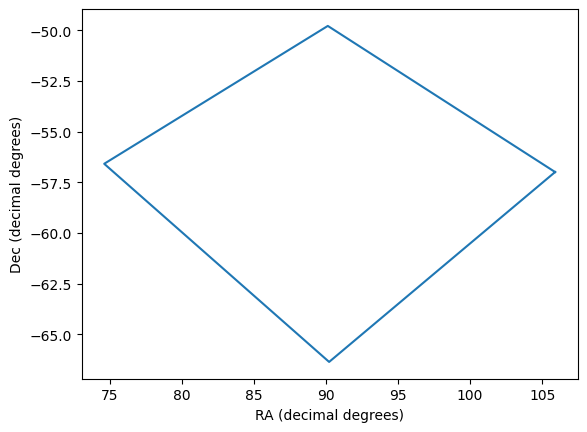

In [6]:
example_RAs=[float(FFIs['s_region'][0].split(' ')[i]) for i in [1,3,5,7,9]]
example_Decs=[float(FFIs['s_region'][0].split(' ')[i]) for i in [2,4,6,8,10]]
plt.plot(example_RAs,example_Decs)
plt.xlabel('RA (decimal degrees)')
plt.ylabel('Dec (decimal degrees)')

These coordinates do not look particularly square, because we are representing a portion of a sphere with a flat surface and we did not attempt to account for any projection effects. We know for sure that if our target is within 6 degrees of the center, it will be within the CCD's field of view (this defines the largest circle that can fit inside the square). A target at the corner of the field of view would be about $\sqrt{(6^\circ)^2+(6^\circ)^2} \approx 8.5^\circ$ away from the center; but not all targets between $6^\circ$ and $8.5^\circ$ are within the field of view. 

For the purposes of this tutorial, we'll just see if targets are within $6^\circ$ of the center of the CCD. To do a more complete search, which would include targets in the corners of the square (outside of the central circle), you could either use linear algebra concepts or install new Python packages such as [Regions](https://astropy-regions.readthedocs.io/en/stable/index.html) (see Additional Exercises).

### Exercise 1
Find an FFI region whose center Declination is greater than $0^\circ$ and less than $+30^\circ$. Draw a shape that represents the region (as above). Does your region look more or less square than the example shown above? Why? 

Optionally, on the same plot, add a scatter plot of dots representing the coordinates of transients from the ``tab`` table. Hints for the optional portion:
- See [Setup SkyCoord and DateTime objects](#Setup-SkyCoord-and-DateTime-objects) for how to create a SkyCoordinate object for each transient, then plot using decimal degrees in RA (horizontal axis) and Dec (vertical axis).
- You'll need to manually set the plot range (or turn off autoscaling) when adding the scatter plot of transient coordinates. 

In [7]:
# Write your code for Exercise 1 here

## See which transients were observed by TESS at the right time

We are interested in which transient targets in our table ``tab`` are within 6$^\circ$ of the center of a Full Frame Image. But moreso, we are interested in those observed by TESS *during* the transient event. We'd like to know if any of the time period from half-peak to peak and back to half-peak again is captured in the TESS data. Because the TESS segments are about 27 days, we'll be interested in observations with start time is up to 26 days before the first half-peak or up to the start of the second half-peak. 

Let's create columns to record the total number of TESS FFI's that contain the target (``nTESS``), and the number that contain the target and are timed correctly (``nTESStimed``).

In [8]:
tab.add_column(np.zeros(len(tab),dtype=int),name='nTESS')
tab.add_column(np.zeros(len(tab),dtype=int),name='nTESStimed')

### Setup SkyCoord and DateTime objects

To determine distances on the sky, we'll want to use [astropy SkyCoord objects](https://docs.astropy.org/en/stable/coordinates/index.html). Likewise, to determine differences in dates and times, we'll use [astropy DateTime objects](https://docs.astropy.org/en/stable/time/index.html). 

In [9]:
# Create SkyCoordinate objects for each row in the FFI table
FFIs['SkyCoord']=SkyCoord(FFIs['s_ra'],FFIs['s_dec'],unit=(u.deg,u.deg))

In [10]:
# Create SkyCoordinate objects for each row in the target table.
tab['SkyCoord']=SkyCoord(tab['RA'],tab['Dec'],unit=(u.hourangle,u.deg))

In [11]:
# Create peak Time objects for reach row in the target table.
tab['peakTime']=Time(tab['peakt']+2458000,format='jd')

We are interested in observations that start at no more than 26 days before the start of the first half peak. Or, observations could start as late as the time of the second half-peak. The start and end times of the FFI's are floats in Modified Julian Day, so we will design these columns to match those from the FFI's. We will simply use the values of lower lower limits, so we'll have to strip the ``>`` character from the ``rise`` and ``fade`` strings.

In [12]:
# Create columns for the min and max mjd, as floats.
tab['minStart']=tab['peakTime'].mjd-[float(row['rise'].strip('>')) for row in tab]-26
tab['maxStart']=tab['peakTime'].mjd+[float(row['fade'].strip('>')) for row in tab]

### Exercise 2
Confirm that our MJD minStart and maxStart times are correct for SN2023koy.

In [13]:
# Write your code for Exercise 2 here.

### Search the FFI table for transient objects

Below, we have a for loop that will examine each transient event one at a time. We'll record which FFI's contain the coordinate, as well as which ones are at the right timing. In other words,``arr1`` and ``arr2`` are arrays of the same length as the ``FFIs`` table. The code cell below will take about 20 seconds to run.

In [15]:
ntab=len(tab)
for i,row in enumerate(tab):
    # Calculate the separation between each FFI's central SkyCoord and this transient's SkyCoord. 
    # Create a boolean array with element "true" if the separation is less than 6 degrees. 
    arr1=(row['SkyCoord'].separation(FFIs['SkyCoord'])<6*u.deg)
    # Create a boolean array for all FFI's with element "true" if the start time is between
    # our transient's defined min and max.
    arr2=(row['minStart']<=FFIs['t_min']) & (row['maxStart']>=FFIs['t_min'])
    # Record the total number of TESS FFI's that contain the transient coordinate.
    tab['nTESS'][i]=np.sum(arr1)
    # Record the total number of TESS FFI's that contain the transient coordinate AND are at the right time.
    tab['nTESStimed'][i]=np.sum((arr1) & (arr2))
    # Print an update every 1000 transients so we know the code is progressing.
    if np.mod(i,1000)==0 or i==ntab-1: 
        print(i,'/',ntab-1)

0 / 7943
1000 / 7943
2000 / 7943
3000 / 7943
4000 / 7943
5000 / 7943
6000 / 7943
7000 / 7943
7943 / 7943


Let's see how many of our transient objects have TESS observations, and how many have TESS observations timed correctly:

In [16]:
print(np.sum(tab['nTESS']>0))
print(np.sum(tab['nTESStimed']>0))

7120
752


Because TESS has observed the whole sky, it makes sense that almost all of the transients are identified in at least one TESS FFI, though we miss some because of our approximations used above. However, the second number printed above is much smaller, because not all observations will have been at the right time.

## Use TESScut and lightkurve to view the lightcurve of one transient event

Let's choose one transient event to investigate further. [Fausnaugh et. al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...908...51F/abstract) presented a number of lightcurves of Type Ia supernovae observed with TESS, some of which were first discovered by ZTF and will be in our table. Let's look at the one given the name SN2018koy. 

### Determine the desired TESS sector for our target

In [22]:
# Determine the index of SN2018koy and select and view the row of the table.
name='SN2018koy'
i=np.where(tab['IAUID']==name)
row=tab[i]
row

ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V,nTESS,nTESStimed,SkyCoord,peakTime,minStart,maxStart
,,,,,,,,,,,,,,,,,"deg,deg",,,
str12,str10,str11,str11,float64,str1,float64,str6,str8,str7,str8,str10,str7,float64,float64,int64,int64,SkyCoord,Time,float64,float64
ZTF18adaifep,SN2018koy,05:41:13.75,-13:13:27.1,491.74,r,17.2126,-18.74,30.131,13.905,16.226,SN Ia,0.031,-21.44403684,0.376,2,1,"85.30729166666667,-13.224194444444445",2458491.74,58451.335000000225,58507.466000000226


We only noted how many correctly timed TESS observations were available for this transient; now we need to actually determine which sectors they correspond to. Now we'll use query_criteria to find the MAST observations that meet our criteria:
- ``objectname`` = SN2018koy; MAST will resolve that recognized name into a coordinate and do a cone search.
- ``target_name = TESS FFI``
- ``t_min``, start time between the previously determined limits

In [23]:
minStart = row['minStart'][0]
maxStart = row['maxStart'][0]
obs_table=Observations.query_criteria(objectname=name,radius=0,project='TESS',target_name='TESS FFI',
                               t_min=[minStart,maxStart])
obs_table

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str4,str10,str4,str4,str7,str8,str1,str14,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str1,float64,str3,str1,int64,str108,str1,str1,str6,bool,float64,str8,str9,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0006-2-4,86.20076433960975,-12.290026174766716,image,"Ricker, George",3,58467.77524697917,58489.54576832176,1425.59941,600.0,1000.0,--,58541.8333333,N/A,--,6,POLYGON 92.524765 -6.513264 92.23118 -18.413969 79.397962 -17.686918 80.643378 -6.268166 92.524765 -6.513264,--,--,PUBLIC,False,nan,62280345,116427561,116427561,0.0


We can extract the sector from the obs_id string, but it is also conveniently in the ``sequence_number`` field (see the [MAST documentation about table columns](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html)).

In [24]:
sectors=obs_table['sequence_number']
sectors

6


TESS Sector 6 observed this target within the time frame we specified.

### Use TESSCut to create a postage stamp of our target

The lightkurve package has a built-in search method for using TESSCut, which creates a cutout of a TESS FFI time series for a region on the sky. The FFI itself is quite large, and we want to zoom in on only our target coordinate. In addition to searching by our target name (which will again be resolved into coordinates), we only want the sectors determined above.

In [25]:
search_result=lk.search_tesscut(name,sector=sectors)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 06,2018,TESScut,1426,SN2018koy,0.0


We want to download the cutout; we will use a 9x9 cutout. This size will include our target with enough pixels to establish a background. 

In [27]:
size=9
tpf = search_result.download_all(cutout_size=size)

We have saved the target pixel file (TPF) locally at mastDownload/HLSP and loaded it in to the variable ``tpf``. 
Additionally, we can see that the size of the ``tpf[0].flux``:

In [28]:
np.shape(tpf[0].flux)

(981, 9, 9)

There are 981 images, each of size 9x9 pixels. Note that when this notebook is run locally, you can use the tpf.interact() feature to examine this TPF interactively. At the time of this writing, this feature is not available when using the TIKE platform.

Let's view the first and last images:

<AxesSubplot:title={'center':'Target ID: SN2018koy, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

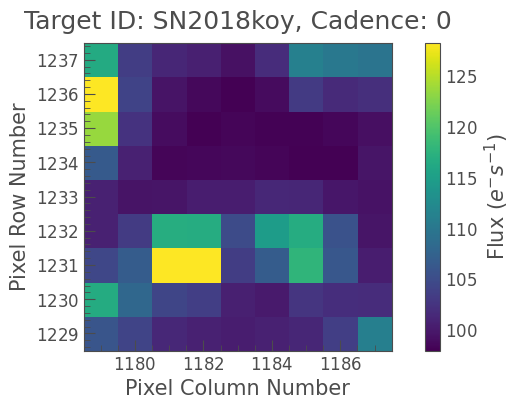

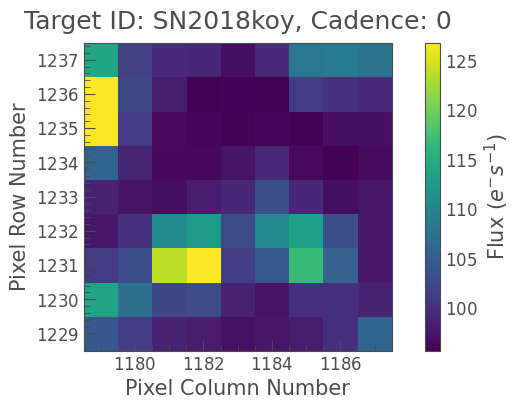

In [29]:
tpf[0][0].plot()
tpf[0][-1].plot()

By eye, it does seem like the central pixels get slightly brighter from the first to last image, implying that we have caught the supernova while it is brightening. Because these galaxies are not TESS targets (bright stars around which we are looking for exoplanets), there is no pre-defined pipeline aperture mask. There are procedures to use thresholding to create an aperture mask: [How to cut out Target Pixel Files from Kepler Superstamps or TESS FFIs?](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-1-cutting-out-tpfs.html) For our purposes, we will just create a mask that examines the central pixel in our 9x9 grid, which will most closely align with the supernova's coordinates.

### Create a background-subtracted lightcurve

<AxesSubplot:title={'center':'Target ID: SN2018koy, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

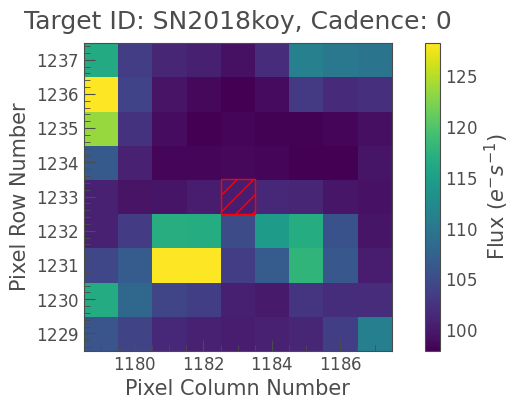

In [30]:
central_index = np.floor(size / 2.0).astype(int)
target_mask = np.full((size, size), False, dtype=bool)
# Set the central element to True
target_mask[central_index, central_index] = True
tpf[0].plot(aperture_mask=target_mask)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

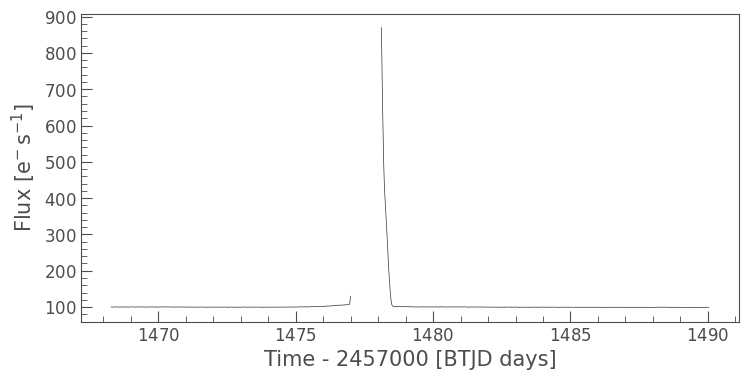

In [31]:
target_lc=tpf[0].to_lightcurve(aperture_mask=target_mask)
target_lc.plot()

The large change when the TESS instrument completes an orbit is instrumental; we also need to take into account the background flux and how it may change. 

<AxesSubplot:title={'center':'Target ID: SN2018koy, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

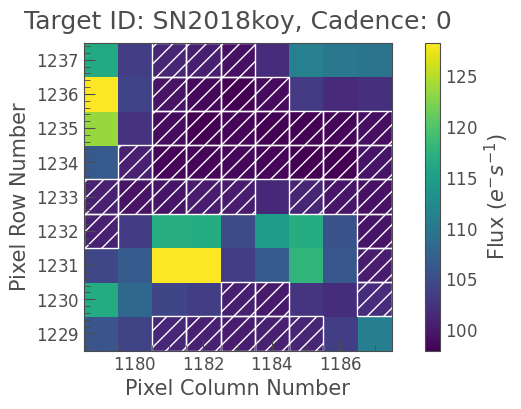

In [32]:
background_mask = ~tpf[0].create_threshold_mask(threshold=0.001, reference_pixel=None)
tpf[0].plot(aperture_mask=background_mask,mask_color='w')

In our case, the central pixels have been chosen as background pixels; but we know the supernova will occur there! We will manually remove a few from the background mask. 

In [33]:
background_mask[4,4]=False
background_mask[5,4]=False # Not sure why indexing is opposite how viewed, but this makes plot correct.
background_mask[5,5]=False

<AxesSubplot:title={'center':'Target ID: SN2018koy, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

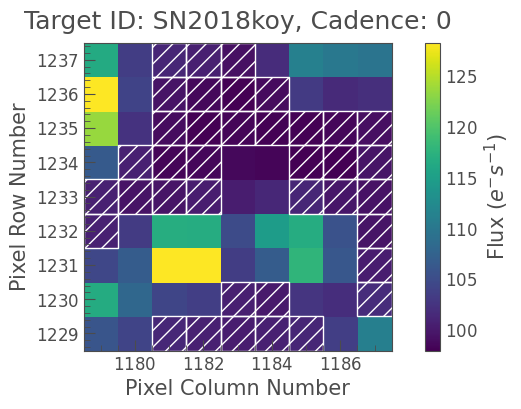

In [34]:
n_background_pixels = background_mask.sum()
background_lc_per_pixel = tpf[0].to_lightcurve(aperture_mask=background_mask) / n_background_pixels
tpf[0].plot(aperture_mask=background_mask,mask_color='w')

Let's view the final background-subtracted lightcurve of the central pixel, and draw vertical lines that correspond to the ZTF reported peak time (solid) and first half-peak time (dashed).

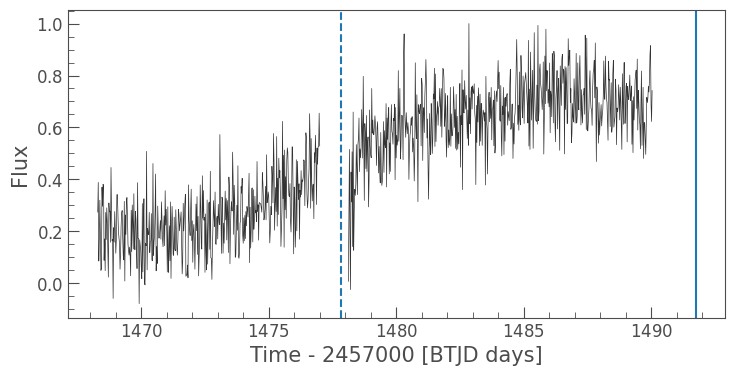

In [35]:
corrected_lc = target_lc - background_lc_per_pixel.flux
peaknorm_lc=corrected_lc/np.nanmax(corrected_lc.flux)
peaknorm_lc.plot()
plt.axvline(row['peakTime'].jd-2457000,linestyle='solid')
plt.axvline(row['peakTime'].jd-2457000-float(row['rise'][0].strip('>')),linestyle='dashed')

The brightness change in this central pixel is noticeable, and the change qualitatively similar to that reported in Figure 35 of [Fausnaugh et. al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...908...51F/abstract).  More detailed processing steps are described therein.

## Additional Exercises
3. New target mask: In addition to the central pixel, the 3 surrounding pixels (that we removed from the background mask) also seem to show brightening. How does the light curve change when those pixels are included in the target mask? 

4. Another supernova: Another target in [Fausnaugh et. al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...908...51F/abstract) is SN2018fhw (or ASASSN-18tb). Is this target included in our table from ZTF? Use information from our table or from the published paper to plot its background-subtracted lightcurve from TESS data. (Hint: the transient event occurs over two separate observing sectors! Look at Figure 1 of the paper.)

5. A more thorough search: Searching the regions properly using linear algebra or regions.

## Citations

If you use `astropy`, `lightkurve`, or `TESSCut` for published research, please cite the
authors. Follow these links for more information about citing:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* If you use TESSCut for your work, please cite [Brasseur et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ascl.soft05007B/abstract)
* [Citing MAST missions](https://archive.stsci.edu/publishing/mission-acknowledgements)

## About this Notebook
For support, please contact the Archive HelpDesk at archive@stsci.edu.

**Author(s):** Julia Kamenetzky, ScienceBetter Consultatnt  
**Keyword(s):** Tutorial, TIKEBook, TESSCut, FFI, transients, galaxies  
**Last Updated:** Jul 2023  
**Next Review:** Jan 2024  
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 